In [26]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from collections import Counter


# For text preprocessing
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.util import ngrams

# For Predictions
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

In [2]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')


# For dataset loading
from sklearn.datasets import fetch_20newsgroups


# Set random seed for reproducibility
np.random.seed(42)


# Load a subset of the 20 Newsgroups dataset
categories = ['comp.graphics', 'rec.autos', 'sci.space', 'talk.politics.misc']
newsgroups = fetch_20newsgroups(subset='train', categories=categories, random_state=42,remove=('headers','footers','quotes'))

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gigepogden/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gigepogden/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/gigepogden/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/gigepogden/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/gigepogden/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/gigepogden/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [3]:
stop_words = set(stopwords.words('english'))

In [4]:
# Create a DataFrame for easier manipulation
df = pd.DataFrame({
   'text': newsgroups.data,
   'category': [newsgroups.target_names[target] for target in newsgroups.target]
})

In [5]:
# Preview the data
print(f"Dataset shape: {df.shape}")
print("\nCategory distribution:")
print(df['category'].value_counts())
print("\nSample document:")
print(df['text'][750][:500])  # Print first 500 characters of a sample document
print('Category is',df['category'][750])

Dataset shape: (2236, 2)

Category distribution:
category
rec.autos             594
sci.space             593
comp.graphics         584
talk.politics.misc    465
Name: count, dtype: int64

Sample document:

There was a Science fiction movie sometime ago (I do not remember its 
name) about a planet in the same orbit of Earth but hidden behind the 
Sun so it could never be visible from Earth. Turns out that that planet 
was the exact mirror image of Earth and all its inhabitants looked like 
the Earthings with the difference that their organs was in the opposite 
side like the heart was in the right side instead in the left and they 
would shake hands with the left hand and so on...

 C.O.EGALON@LAR
Category is sci.space


In [6]:
lemmatizer = WordNetLemmatizer()
# Helper function for lemmatization with POS tagging
def get_wordnet_pos(treebank_tag):
    """
    Convert NLTK POS tags to WordNet POS tags
    """
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Lemmatization function
def lemmatize_tokens(tokens):
    """
    Lemmatize tokens with appropriate POS tags
    
    Parameters:
    tokens (list): List of word tokens
    
    Returns:
    list: Lemmatized tokens
    """
    # Tag tokens with parts of speech
    tokens_tagged = nltk.pos_tag(tokens)
    
    # Convert to WordNet POS tags
    pos_tokens = [(word[0],get_wordnet_pos(word[1])) for word in tokens_tagged]
    
    # Lemmatize with POS tags
    lemmatized = [lemmatizer.lemmatize(word[0],word[1]) for word in pos_tokens]
    
    return lemmatized

In [7]:

def preprocess_text(text, remove_stopwords=True, lemmatize=True):
    # Convert to lowercase
    clean_txt = text.lower()
    # Remove special characters/numbers
    clean_txt = re.sub(r'[^a-zA-Z0-9 ]', '', clean_txt)
    # Tokenize
    tokens = word_tokenize(clean_txt)
    filtered_tokens = [token for token in tokens if not token.isnumeric()]
    filtered_tokens = [token for token in tokens if len(token) > 0]
    # Optional: Remove stopwords
    
    filtered_tokens = [token for token in filtered_tokens if token not in stop_words]
    
    # Lemmatize or stem tokens
    final_tokens = lemmatize_tokens(filtered_tokens)
    # Return the cleaned token list
    return final_tokens

In [8]:
df['processed_tokens'] = df['text'].apply(preprocess_text)

In [9]:
def create_corpus(list_of_lists):
    all_tokens = [token for doc in list_of_lists]

In [10]:
# Single words
counter = Counter([token for doc in df['processed_tokens'] for token in doc])
print(counter.most_common(20))

# Bigrams
from nltk.util import ngrams
bigram_counts = Counter(ngrams(df['processed_tokens'].sum(), 2))
print(bigram_counts.most_common(20))

[('would', 1184), ('get', 1114), ('use', 1036), ('one', 917), ('go', 874), ('make', 831), ('know', 818), ('space', 811), ('think', 795), ('say', 788), ('dont', 779), ('like', 748), ('image', 740), ('people', 720), ('also', 695), ('time', 654), ('work', 640), ('well', 626), ('car', 625), ('program', 623)]
[(('mr', 'stephanopoulos'), 341), (('dont', 'know'), 153), (('dont', 'think'), 84), (('im', 'sure'), 76), (('would', 'like'), 76), (('m', 'myers'), 75), (('united', 'state'), 70), (('white', 'house'), 63), (('anyone', 'know'), 62), (('anonymous', 'ftp'), 61), (('health', 'care'), 56), (('administration', 'official'), 53), (('space', 'shuttle'), 52), (('new', 'york'), 52), (('senior', 'administration'), 51), (('stephanopoulos', 'dont'), 49), (('year', 'ago'), 48), (('young', 'people'), 47), (('space', 'station'), 46), (('los', 'angeles'), 43)]


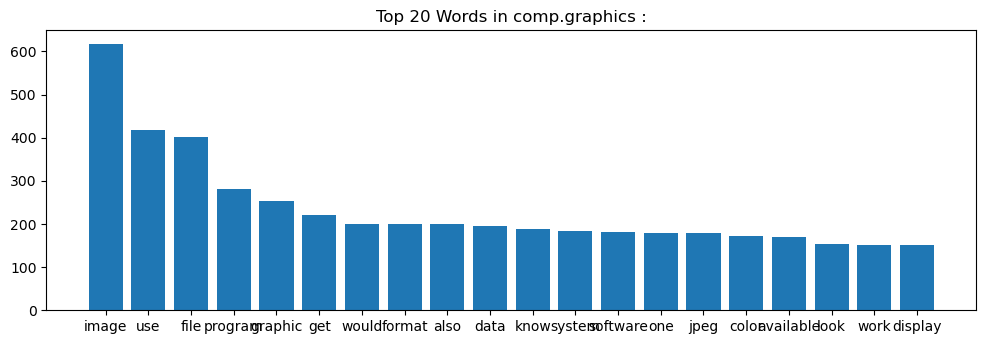

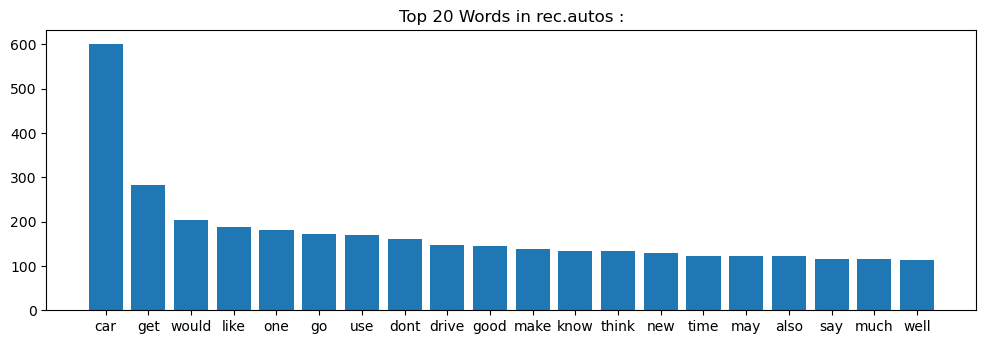

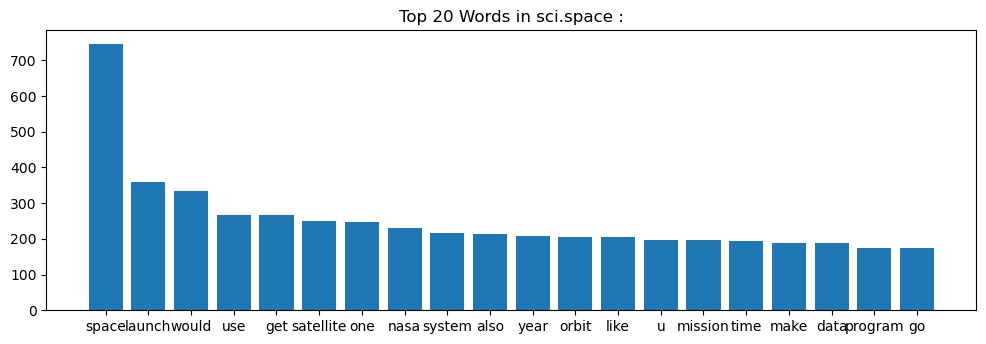

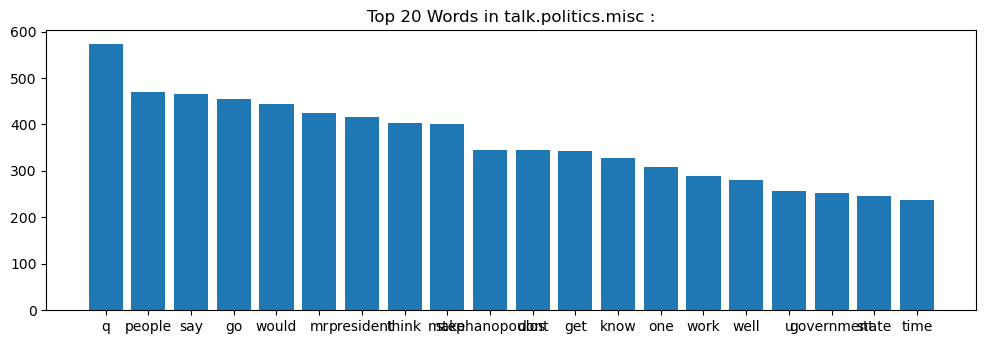

In [12]:
for cat in categories:
    line = "Top 20 Words in " + cat +" :"
    category_token = df[df['category']==cat]['processed_tokens']
    cat_counter = Counter([token for doc in category_token for token in doc])
    # Visualize top tokens and bigrams
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    frequent_tokens=cat_counter.most_common(20)
    tkns = [t[0] for t in frequent_tokens]
    counts = [t[1] for t in frequent_tokens]
    plt.bar(tkns,counts)
    plt.title(line)
 


# Classification Model
Build the model as follows:

1. Split the data first! We cannot do step 2 with the entire corpus because new dat

2. Create numerical representation for each observation w/ TF-IDF.  This is much better than bag of words because, as we can see in the earlier section, there are a lot of shared words that do not offer any info about the document's true category.

3. Make sure to also isolate the target label (category). 

4. Train the model.  We will try a simple nearest neighbors approach but quickly fabor a multinomial naive bayes model after doing some research on the matter.

Lastly, we will tweak this process by exploring different values for the TFidfVectorizer's parameter, max_df.

When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words). If float in range [0.0, 1.0], the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.


In [13]:
y = df['category']
X = df['text']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [14]:
documents = X_train

In [15]:
# Create a TfidfVectorizer object
vectorizer = TfidfVectorizer()

# Fit and transform the documents
tfidf_matrix_train = vectorizer.fit_transform(documents)

# Get the feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Convert the TF-IDF matrix to an array
tfidf_array_train = tfidf_matrix_train.toarray()

In [16]:
tfidf_matrix_test = vectorizer.transform(X_test)
tfidf_array_test = tfidf_matrix_test.toarray()

In [17]:
print(tfidf_array_train.shape[1])
print(tfidf_array_test.shape[1])

24524
24524


In [19]:
knn = KNeighborsClassifier()
knn.fit(tfidf_array_train,y_train);

In [20]:
predictions = knn.predict(tfidf_array_test)
accuracy_score(y_test,predictions)

0.32589285714285715

Ouch!  Very very poor.

In [22]:
mb = MultinomialNB()
mb.fit(tfidf_array_train,y_train);

In [23]:
predictions = mb.predict(tfidf_array_test)
accuracy_score(y_test,predictions)

0.8861607142857143

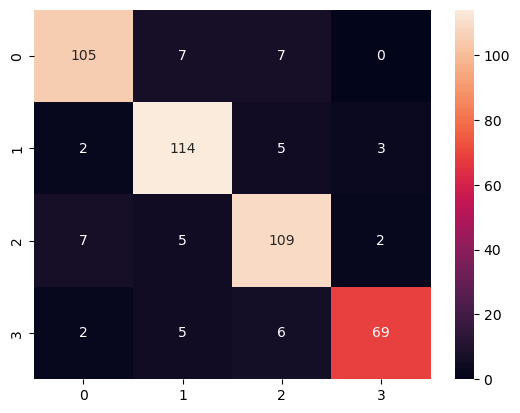

In [28]:
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [37]:
# Create a TfidfVectorizer object
vectorizer = TfidfVectorizer(max_df=0.25)

# Fit and transform the documents
tfidf_matrix_train = vectorizer.fit_transform(documents)

# Get the feature names (words)
feature_names_2 = vectorizer.get_feature_names_out()

# Convert the TF-IDF matrix to an array
tfidf_array_train = tfidf_matrix_train.toarray()

In [38]:
tfidf_matrix_test = vectorizer.transform(X_test)
tfidf_array_test = tfidf_matrix_test.toarray()

In [39]:
print(tfidf_array_train.shape[1])
print(tfidf_array_test.shape[1])

24491
24491


In [40]:
mb = MultinomialNB()
mb.fit(tfidf_array_train,y_train);

In [41]:
predictions = mb.predict(tfidf_array_test)
accuracy_score(y_test,predictions)

0.8928571428571429

Interesting, it is difficult to get the feature space down at all but we do get a bit of better performance. 